# Titanic CNN

## 概要：
- 将主要的13维数据移动到40*40图片的中央区域。避免在最数组开头，变成图片之后在边缘，卷积的时候，特征提取不充分。
- 运行时间比较长的训练，还是应该弄个TensorBoard，方便监控结果，免得每次都需要用鼠标手动托页面查看最新的运行结果。
- 数据用StandardScaler归一化，避免卷积的时候，有些值特别大，覆盖了其他值。

Reference: 
1. https://www.kaggle.com/c/titanic#tutorials
2. https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
3. https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook


## 1. Preprocess

### Import pkgs

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

%matplotlib inline

In [2]:
cwd = os.getcwd()
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())

model_path = os.path.join(cwd, 'model')
log_path = os.path.join(cwd, 'log')

### Import original data as DataFrame

In [3]:
data_train = pd.read_csv('./input/train.csv')
data_test = pd.read_csv('./input/test.csv')

display(data_train.head(2))
display(data_test.head(2))
print(data_train.shape)
print(data_test.shape)

data_train.loc[2, 'Ticket']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


(891, 12)
(418, 11)


'STON/O2. 3101282'

### Show columns of dataframe

In [4]:
data_train_original_col = data_train.columns
data_test_original_col = data_test.columns
print(data_train_original_col)
print(data_test_original_col)
# data_train0 = data_train.drop(data_train_original_col, axis = 1)
# data_test0  = data_test.drop(data_test_original_col, axis = 1)
# display(data_train0.head(2))
# display(data_test0.head(2))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### Preprocess features

In [5]:
# Get survived
survived = data_train['Survived']

In [6]:
# Drop survived to align columns of data_train and data_test
data_train = data_train.drop('Survived', axis = 1)

In [7]:
dataset = data_train.append(data_test)
print(dataset.shape)
dataset_original_columns = dataset.columns
print(dataset_original_columns)

(1309, 11)
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [8]:
# Pclass
temp = dataset[dataset['Pclass'].isnull()]
if len(temp) == 0:
    print('Do not have null value!')
else:
    temp.head(2)
        
dataset['a_Pclass'] = dataset['Pclass']
# display(dataset.head())

Do not have null value!


In [9]:
# Name
dataset['a_Name_Length'] = dataset['Name'].apply(len)
# display(dataset.head(2))

In [10]:
# Sex
dataset['a_Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
# display(dataset.head(2))

In [11]:
# Age
dataset['a_Age'] = dataset['Age'].fillna(-1)
dataset['a_Have_Age'] = dataset['Age'].isnull().map({True: 0, False: 1}).astype(int)
# display(dataset[dataset['Age'].isnull()].head(2))
# display(dataset.head(2))

In [12]:
# SibSp and Parch
dataset['a_FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
dataset['a_IsAlone'] = dataset['a_FamilySize'].apply(lambda x: 1 if x<=1 else 0)
# display(dataset.head(2))

In [13]:
# Ticket(Very one have a ticket)
dataset['a_Have_Ticket'] = dataset['Ticket'].isnull().map({True: 0, False: 1}).astype(int)
# display(dataset[dataset['Ticket'].isnull()].head(2))
# display(dataset.head(2))

In [14]:
# Fare
dataset['a_Fare'] = dataset['Fare'].fillna(-1)
dataset['a_Have_Fare'] = dataset['Fare'].isnull().map({True: 0, False: 1}).astype(int)
# display(dataset[dataset['Fare'].isnull()].head(2))
# display(dataset.head(2))

In [15]:
# Cabin
dataset['a_Have_Cabin'] = dataset['Cabin'].isnull().map({True: 0, False: 1}).astype(int)
# display(dataset[dataset['Cabin'].isnull()].head(2))
# display(dataset.head(2))

In [16]:
# Embarked
#     dataset['Embarked'] = dataset['Embarked'].fillna('N')
dataset['a_Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2, None: 3} ).astype(int)
dataset['a_Have_Embarked'] = dataset['Embarked'].isnull().map({True: 0, False: 1}).astype(int)
#     display(dataset[dataset['Embarked'].isnull()].head(2))
# display(dataset.head(2))
# print(len(dataset.columns))

Name words segmentation and one-hote

In [17]:
# Name words segmentation
import re
name_words = []

# Inorder to allign columns of data_train and data_test, only data_train to fetch word
for name in dataset['Name']:
#     print(name)
    words = re.findall(r"[\w']+", name)
#     print(len(words))
#     print(words)
    for w in words:
        if w not in name_words:
            name_words.append(w)
# print(len(name_words))
name_words.sort()
# print(name_words)

In [18]:
# Add columns
for w in name_words:
    col_name = 'a_Name_' + w
    dataset[col_name] = 0
dataset.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,a_Name_Zimmerman,a_Name_de,a_Name_del,a_Name_der,a_Name_hoef,a_Name_of,a_Name_the,a_Name_van,a_Name_von,a_Name_y
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Name words one-hote
for i, row in dataset.iterrows():
#     print(row['Name'])
    words = re.findall(r"[\w']+", row['Name'])
    for w in words:
        if w in name_words:
            col_name = 'a_Name_' + w
            dataset.loc[i, col_name] = 1
#     display(dataset[dataset['a_Name_Braund'] == 1])

Cabin segmentation and one-hote

In [20]:
# Get cabin segmentation words
import re
cabin_words = []

# Inorder to allign columns of data_train and data_test, only data_train to fetch number
for c in dataset['Cabin']:
#     print(c)
    if c is not np.nan:
        word = re.findall(r"[a-zA-Z]", c)
#         print(words[0])
        cabin_words.append(word[0])
print(len(cabin_words))
cabin_words.sort()
print(np.unique(cabin_words))
cabin_words_unique = list(np.unique(cabin_words))

295
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T']


In [21]:
def get_cabin_word(cabin):
    if cabin is not np.nan:
        word = re.findall(r"[a-zA-Z]", cabin)
        if word:
            return cabin_words_unique.index(word[0])
    return -1

dataset['a_Cabin_Word'] = dataset['Cabin'].apply(get_cabin_word)
# dataset['a_Cabin_Word'].head(100)

In [22]:
def get_cabin_number(cabin):
    if cabin is not np.nan:
        word = re.findall(r"[0-9]+", cabin)
        if word:
            return int(word[0])
    return -1


dataset['a_Cabin_Number'] = dataset['Cabin'].apply(get_cabin_number)
print(dataset.shape)
# dataset['a_Cabin_Number'].head(100)

(1309, 1978)


In [23]:
# Clean data
# Reference: 
#    1. https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
#    2. https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook
# full_data = [data_train, data_test]
# for dataset in full_data:
#     dataset['a_Name_length'] = dataset['Name'].apply(len)
#     #dataset['Sex'] = (dataset['Sex']=='male').astype(int)
#     dataset['a_Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
#     dataset['a_Age'] = dataset['Age'].fillna(0)
#     dataset['a_Age_IsNull'] = dataset['Age'].isnull()
#     dataset['a_FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
#     dataset['a_IsAlone'] = dataset['a_FamilySize'].apply(lambda x: 1 if x<=1 else 0)
#     dataset['a_Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
#     #dataset['Has_Cabin'] = dataset['Cabin'].apply(lambda x: 1 if type(x) == str else 0) # same as below
#     dataset['a_Has_Cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
#     dataset['a_Has_Embarked'] = dataset['Embarked'].isnull()
#     dataset['Embarked'] = dataset['Embarked'].fillna('N')
#     dataset['a_Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2, 'N': 3} ).astype(int)
#     dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
# display(data_train.head(2))
# display(data_test.head(2))

In [24]:
# Drop old columns
print(dataset_original_columns)
print(dataset.shape)
full_data  = dataset.drop(dataset_original_columns, axis = 1)
print(full_data.shape)
display(full_data.iloc[0:15])

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(1309, 1978)
(1309, 1967)


,a_Pclass,a_Name_Length,a_Sex,a_Age,a_Have_Age,a_FamilySize,a_IsAlone,a_Have_Ticket,a_Fare,a_Have_Fare,...,a_Name_del,a_Name_der,a_Name_hoef,a_Name_of,a_Name_the,a_Name_van,a_Name_von,a_Name_y,a_Cabin_Word,a_Cabin_Number
0,3,23,1,22.0,1,2,0,1,7.2500,1,...,0,0,0,0,0,0,0,0,-1,-1
1,1,51,0,38.0,1,2,0,1,71.2833,1,...,0,0,0,0,0,0,0,0,2,85
2,3,22,0,26.0,1,1,1,1,7.9250,1,...,0,0,0,0,0,0,0,0,-1,-1
3,1,44,0,35.0,1,2,0,1,53.1000,1,...,0,0,0,0,0,0,0,0,2,123
4,3,24,1,35.0,1,1,1,1,8.0500,1,...,0,0,0,0,0,0,0,0,-1,-1
5,3,16,1,-1.0,0,1,1,1,8.4583,1,...,0,0,0,0,0,0,0,0,-1,-1
6,1,23,1,54.0,1,1,1,1,51.8625,1,...,0,0,0,0,0,0,0,0,4,46
7,3,30,1,2.0,1,5,0,1,21.0750,1,...,0,0,0,0,0,0,0,0,-1,-1
8,3,49,0,27.0,1,3,0,1,11.1333,1,...,0,0,0,0,0,0,0,0,-1,-1
9,2,35,0,14.0,1,2,0,1,30.0708,1,...,0,0,0,0,0,0,0,0,-1,-1


In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
data = [[0, 0, 0], 
        [0, -1, 0], 
        [1, 10, -10], 
        [1, 15, 10]]
scaler = MinMaxScaler()
print(scaler.fit(data))
print(scaler.transform(data))
print('*'*40)
scaler = StandardScaler()
print(scaler.fit(data))
print(scaler.mean_)
print(scaler.transform(data))

MinMaxScaler(copy=True, feature_range=(0, 1))
[[ 0.      0.0625  0.5   ]
 [ 0.      0.      0.5   ]
 [ 1.      0.6875  0.    ]
 [ 1.      1.      1.    ]]
****************************************
StandardScaler(copy=True, with_mean=True, with_std=True)
[ 0.5  6.   0. ]
[[-1.         -0.88949918  0.        ]
 [-1.         -1.03774904  0.        ]
 [ 1.          0.59299945 -1.41421356]
 [ 1.          1.33424877  1.41421356]]


In [26]:
# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(full_data)
full_data0 = scaler.transform(full_data)
print(full_data0[0:15, 0:5])

[[ 0.84191642 -0.43467223  0.74349692 -0.09387797  0.50143198]
 [-1.54609786  2.51180578 -1.34499549  0.80201077  0.50143198]
 [ 0.84191642 -0.53990359 -1.34499549  0.13009422  0.50143198]
 [-1.54609786  1.77518628 -1.34499549  0.63403164  0.50143198]
 [ 0.84191642 -0.32944087  0.74349692  0.63403164  0.50143198]
 [ 0.84191642 -1.17129173  0.74349692 -1.38171803 -1.99428842]
 [-1.54609786 -0.43467223  0.74349692  1.69789952  0.50143198]
 [ 0.84191642  0.30194727  0.74349692 -1.21373889  0.50143198]
 [ 0.84191642  2.30134307 -1.34499549  0.18608726  0.50143198]
 [-0.35209072  0.82810406 -1.34499549 -0.54182234  0.50143198]
 [ 0.84191642  0.40717863 -1.34499549 -1.1017528   0.50143198]
 [-1.54609786 -0.32944087 -1.34499549  1.9218717   0.50143198]
 [ 0.84191642  0.30194727  0.74349692 -0.20586406  0.50143198]
 [ 0.84191642 -0.0137468   0.74349692  0.85800382  0.50143198]
 [ 0.84191642  0.93333542 -1.34499549 -0.54182234  0.50143198]]


In [27]:
features = full_data.iloc[0:891]
data_test0 = full_data.iloc[891:]
print(features.shape)
print(data_test0.shape)
# display(features.head(2))

(891, 1967)
(418, 1967)


Check and confirm all columns is proccessed

In [28]:
for col in features.columns:
    if not col.startswith('a_'):
        print(col)

In [29]:
# Shuffle and split the train_data into train, crossvalidation and testing subsets
x_train, x_val, y_train, y_val = train_test_split(features, survived, test_size=0.2, random_state=2017)

In [30]:
# Show distribute of abave data sets
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
display(x_train.head(2))
display(y_train.head(2))

(712, 1967)
(179, 1967)
(712,)
(179,)


,a_Pclass,a_Name_Length,a_Sex,a_Age,a_Have_Age,a_FamilySize,a_IsAlone,a_Have_Ticket,a_Fare,a_Have_Fare,...,a_Name_del,a_Name_der,a_Name_hoef,a_Name_of,a_Name_the,a_Name_van,a_Name_von,a_Name_y,a_Cabin_Word,a_Cabin_Number
304,3,33,1,-1.0,0,1,1,1,8.05,1,...,0,0,0,0,0,0,0,0,-1,-1
149,2,33,1,42.0,1,1,1,1,13.00,1,...,0,0,0,0,0,0,0,0,-1,-1


304    0
149    0
Name: Survived, dtype: int64

## Fullfil matrix to 16000 and Reshape matrix

In [31]:
x_train0 = x_train.as_matrix()
y_train0 = y_train.as_matrix()
x_val0 = x_val.as_matrix()
y_val0 = y_val.as_matrix()
x_test0 = data_test0.as_matrix()

target_shape = (45, 45)
extend_widgth = target_shape[0]*target_shape[1] - x_train0.shape[1]
print('Target shape: ', target_shape)
print('Extend_widgth: ', extend_widgth)
print('Before extend:')
print(x_train0.shape)
print(x_val0.shape)
print(x_test0.shape)

x_train_ext = np.zeros((x_train0.shape[0], extend_widgth))
x_val_ext = np.zeros((x_val0.shape[0], extend_widgth))
x_test_ext = np.zeros((x_test0.shape[0], extend_widgth))

x_train0 = np.column_stack((x_train0, x_train_ext))
x_val0 = np.column_stack((x_val0, x_val_ext))
x_test0 = np.column_stack((x_test0, x_test_ext))

print('After extend:')
print(x_train0.shape)
print(x_val0.shape)
print(x_test0.shape)

x_train0 = x_train0.reshape(-1, target_shape[0], target_shape[1], 1)
x_val0 = x_val0.reshape(-1, target_shape[0], target_shape[1], 1)
x_test0 = x_test0.reshape(-1, target_shape[0], target_shape[1], 1)

print('After reshape:')
print(x_train0.shape)
print(x_val0.shape)
print(x_test0.shape)

Target shape:  (45, 45)
Extend_widgth:  58
Before extend:
(712, 1967)
(179, 1967)
(418, 1967)
After extend:
(712, 2025)
(179, 2025)
(418, 2025)
After reshape:
(712, 45, 45, 1)
(179, 45, 45, 1)
(418, 45, 45, 1)


## 2. Build CNN

In [32]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [33]:
annealer = LearningRateScheduler(lambda x: 1e-4 * 0.9 ** x)

log_dir = os.path.join(log_path, time_str)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\Kaggle\titanic\log\20180405_135737


In [34]:
model = Sequential()
# Block 1
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'Same',
                 input_shape = (45, 45, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.5))
# Block 2
# model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.5))
# Block 3
# model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding = 'Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.5))
# Block 4
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(strides=(2,2)))
# model.add(Dropout(0.5))
# Block 5
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding = 'Same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(strides=(2,2)))
# model.add(Dropout(0.25))

# Output
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(x_train0, y_train0, 
                 batch_size = 8, 
                 verbose=1,
                 epochs = 20,
                 validation_data=(x_val0, y_val0), 
                 callbacks=[annealer, tensorBoard])

Train on 712 samples, validate on 179 samples
Epoch 1/20
712/712 [==============================] - 24s 34ms/step - loss: 1.4477 - acc: 0.5590 - val_loss: 0.6146 - val_acc: 0.7207
Epoch 2/20
712/712 [==============================] - 22s 31ms/step - loss: 1.4453 - acc: 0.5449 - val_loss: 0.6046 - val_acc: 0.7095
Epoch 3/20
712/712 [==============================] - 22s 31ms/step - loss: 1.3193 - acc: 0.5562 - val_loss: 0.5896 - val_acc: 0.7151
Epoch 4/20
712/712 [==============================] - 22s 31ms/step - loss: 1.1246 - acc: 0.5857 - val_loss: 0.5508 - val_acc: 0.7877
Epoch 5/20
712/712 [==============================] - 23s 32ms/step - loss: 1.0985 - acc: 0.5758 - val_loss: 0.5395 - val_acc: 0.7765
Epoch 6/20
712/712 [==============================] - 22s 31ms/step - loss: 0.9606 - acc: 0.5997 - val_loss: 0.5317 - val_acc: 0.7542
Epoch 7/20
712/712 [==============================] - 22s 31ms/step - loss: 0.8801 - acc: 0.5983 - val_loss: 0.5363 - val_acc: 0.7430
Epoch 8/20
712/7

In [35]:
final_loss, final_acc = model.evaluate(x_val0, y_val0, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

179/179 [==============================] - 1s 8ms/step
Final loss: 0.5459, final accuracy: 0.7486


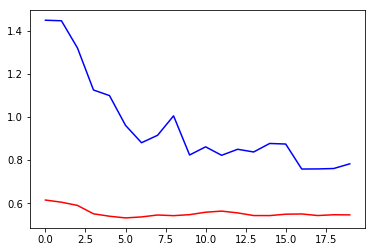

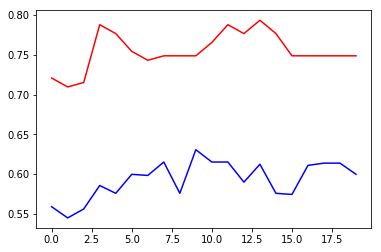

In [36]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

### Predict and Export pred.csv file

In [37]:
train_cols = data_train.columns
for col in data_test0.columns:
    if col not in train_cols:
        print(col)

a_Pclass
a_Name_Length
a_Sex
a_Age
a_Have_Age
a_FamilySize
a_IsAlone
a_Have_Ticket
a_Fare
a_Have_Fare
a_Have_Cabin
a_Embarked
a_Have_Embarked
a_Name_A
a_Name_Aaron
a_Name_Abbing
a_Name_Abbott
a_Name_Abelseth
a_Name_Abelson
a_Name_Abi
a_Name_Abraham
a_Name_Abrahamsson
a_Name_Abrahim
a_Name_Achem
a_Name_Achille
a_Name_Achilles
a_Name_Ada
a_Name_Adahl
a_Name_Adams
a_Name_Addie
a_Name_Adelaide
a_Name_Adele
a_Name_Adelia
a_Name_Adola
a_Name_Adolf
a_Name_Adolfina
a_Name_Adolphe
a_Name_Adrian
a_Name_Agatha
a_Name_Agda
a_Name_Agnes
a_Name_Ahlin
a_Name_Ahmed
a_Name_Aijo
a_Name_Aime
a_Name_Aina
a_Name_Akar
a_Name_Aks
a_Name_Albert
a_Name_Albimona
a_Name_Albin
a_Name_Albina
a_Name_Alden
a_Name_Aldworth
a_Name_Alexander
a_Name_Alexandra
a_Name_Alexanteri
a_Name_Alexenia
a_Name_Alfons
a_Name_Alfonzo
a_Name_Alfred
a_Name_Alfrida
a_Name_Algernon
a_Name_Algot
a_Name_Alhomaki
a_Name_Ali
a_Name_Alice
a_Name_Alicia
a_Name_Aline
a_Name_Allen
a_Name_Allis
a_Name_Allison
a_Name_Allum
a_Name_Alma
a_Name_Aloi

a_Name_Wilhelm
a_Name_Wilhelmina
a_Name_Wilhelms
a_Name_Wilkes
a_Name_Wilkinson
a_Name_Willard
a_Name_Willer
a_Name_Willey
a_Name_William
a_Name_Williams
a_Name_Willie
a_Name_Willingham
a_Name_Wills
a_Name_Wilson
a_Name_Windelov
a_Name_Winfield
a_Name_Winifred
a_Name_Winnie
a_Name_Wirz
a_Name_Wiseman
a_Name_Wittevrongel
a_Name_Wizosky
a_Name_Wonnacott
a_Name_Wood
a_Name_Woolf
a_Name_Woolner
a_Name_Worth
a_Name_Wright
a_Name_Wyckoff
a_Name_Yarred
a_Name_Yasbeck
a_Name_Ylio
a_Name_Yoto
a_Name_Young
a_Name_Youseff
a_Name_Yousif
a_Name_Youssef
a_Name_Yousseff
a_Name_Yrois
a_Name_Zabour
a_Name_Zahie
a_Name_Zakarian
a_Name_Zebley
a_Name_Zenni
a_Name_Zillah
a_Name_Zimmerman
a_Name_de
a_Name_del
a_Name_der
a_Name_hoef
a_Name_of
a_Name_the
a_Name_van
a_Name_von
a_Name_y
a_Cabin_Word
a_Cabin_Number


In [38]:
import time
import os

project_name = 'Titanic'
step_name = 'Predict'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
final_acc_str = str(int(final_acc*10000))
run_name = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name)
cwd = os.getcwd()
pred_file = os.path.join(cwd, 'output', run_name + '.csv')
print(pred_file)

Titanic_Predict_20180405_140530_7486
D:\Kaggle\titanic\output\Titanic_Predict_20180405_140530_7486.csv


In [39]:
display(data_test0.head(2))
y_data_pred = model.predict(x_test0)
print(y_data_pred.shape)
y_data_pred = np.squeeze(y_data_pred)
print(y_data_pred.shape)
y_data_pred = (y_data_pred > 0.5).astype(int)
print(y_data_pred)

print(data_test['PassengerId'].shape)
passenger_id = data_test['PassengerId']
output = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_data_pred })

output.to_csv(pred_file , index = False)

,a_Pclass,a_Name_Length,a_Sex,a_Age,a_Have_Age,a_FamilySize,a_IsAlone,a_Have_Ticket,a_Fare,a_Have_Fare,...,a_Name_del,a_Name_der,a_Name_hoef,a_Name_of,a_Name_the,a_Name_van,a_Name_von,a_Name_y,a_Cabin_Word,a_Cabin_Number
0,3,16,1,34.5,1,1,1,1,7.8292,1,...,0,0,0,0,0,0,0,0,-1,-1
1,3,32,0,47.0,1,2,0,1,7.0000,1,...,0,0,0,0,0,0,0,0,-1,-1


(418, 1)
(418,)
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0]
(418,)


In [40]:
# display(data_test0.head(2))
# y_data_pred = clfs['RandomForestClassifier'].predict(data_test0.as_matrix())
# print(y_data_pred.shape)
# y_data_pred = np.squeeze(y_data_pred)
# print(y_data_pred.shape)
# print(data_test['PassengerId'].shape)
# passenger_id = data_test['PassengerId']
# output = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': y_data_pred })

# output.to_csv(pred_file , index = False)

In [41]:
print(run_name)
print('Done!')

Titanic_Predict_20180405_140530_7486
Done!
